In [3]:
# https://www.kaggle.com/wcukierski/example-metric-implementation
import keras; print(keras.__version__)

2.1.3


('Number of true objects:', 28)
('Number of predicted objects:', 27)
Thresh	TP	FP	FN	Prec.
0.500	25	1	2	0.000
0.550	24	2	3	0.000
0.600	22	4	5	0.000
0.650	18	8	9	0.000
0.700	13	13	14	0.000
0.750	4	22	23	0.000
0.800	0	26	27	0.000
0.850	0	26	27	0.000
0.900	0	26	27	0.000
0.950	0	26	27	0.000
AP	-	-	-	0.000


/usr/local/lib/python2.7/dist-packages/skimage/segmentation/_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):


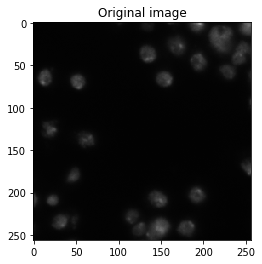

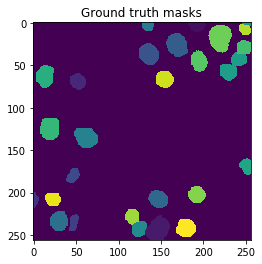

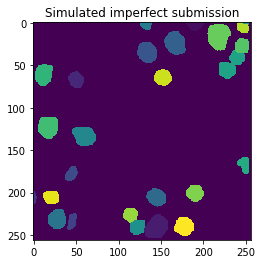

In [2]:
%matplotlib inline
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import skimage.segmentation

# Load a single image and its associated masks
id = '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
file = "data/stage1_train/{}/images/{}.png".format(id,id)
masks = "data/stage1_train/{}/masks/*.png".format(id)
image = skimage.io.imread(file)
masks = skimage.io.imread_collection(masks).concatenate()
height, width, _ = image.shape
num_masks = masks.shape[0]

# Make a ground truth label image (pixel value is index of object label)
labels = np.zeros((height, width), np.uint16)
for index in range(0, num_masks):
    labels[masks[index] > 0] = index + 1

# Show label image
fig = plt.figure()
plt.imshow(image)
plt.title("Original image")
fig = plt.figure()
plt.imshow(labels)
plt.title("Ground truth masks")

# Simulate an imperfect submission
offset = 2 # offset pixels
y_pred = labels[offset:, offset:]
y_pred = np.pad(y_pred, ((0, offset), (0, offset)), mode="constant")
y_pred[y_pred == 20] = 0 # Remove one object
y_pred, _, _ = skimage.segmentation.relabel_sequential(y_pred) # Relabel objects

# Show simulated predictions
fig = plt.figure()
plt.imshow(y_pred)
plt.title("Simulated imperfect submission")

# Compute number of objects
true_objects = len(np.unique(labels))
pred_objects = len(np.unique(y_pred))
print("Number of true objects:", true_objects)
print("Number of predicted objects:", pred_objects)

# Compute intersection between all objects
intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

# Compute areas (needed for finding the union between all objects)
area_true = np.histogram(labels, bins = true_objects)[0]
area_pred = np.histogram(y_pred, bins = pred_objects)[0]
area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

# Compute union
union = area_true + area_pred - intersection

# Exclude background from the analysis
intersection = intersection[1:,1:]
union = union[1:,1:]
union[union == 0] = 1e-9

# Compute the intersection over union
iou = intersection / union

# Precision helper function
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

# Loop over IoU thresholds
prec = []
print("Thresh\tTP\tFP\tFN\tPrec.")
for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    p = tp / (tp + fp + fn)
    print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
    prec.append(p)
print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))